# This notebook will build the model for predicting the price of properties. 
## 1. First basic model based on multiple linear regression.
### 1. import libraries


In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import re
import sys
sys.path.insert(0, '../')
import numpy as np
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from xgboost import XGBRegressor
from src.clean_data import run_cleanup
from src.clean_data import split_df_on_type
from src.linear_model import model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error

### 2. Read the csv-file and put it into a pandas DataFrame

print(df_house.head())
print(df_apt.head())

In [50]:
file_path = '../Data/house_details_v1.csv'
df = pd.read_csv(file_path, index_col='id', skip_blank_lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19963 entries, 10683823 to 10664014
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Street             19963 non-null  object 
 1   Housenumber        19963 non-null  object 
 2   Box                19963 non-null  object 
 3   Floor              19963 non-null  float64
 4   City               19963 non-null  object 
 5   Postalcode         19963 non-null  object 
 6   Type               19963 non-null  object 
 7   Subtype            19963 non-null  object 
 8   Location_area      19963 non-null  object 
 9   Region             19963 non-null  object 
 10  District           19963 non-null  object 
 11  Province           19963 non-null  object 
 12  Price              19963 non-null  float64
 13  Type_of_sale       19963 non-null  object 
 14  Construction_year  19963 non-null  float64
 15  Total_surface      19963 non-null  float64
 16  Habitable_surface

### 3. Clean data via clean_data.py:

In [51]:
drop_columns=[
            'Street', 'Housenumber', 'Box', 'City', 'Subtype', 'Location_area', 'Region', 
            'District', 'Province', 'Type_of_sale', 'Garden', 'Kitchen_type', 'EPC_score', 'Latitude',
            'Longitude', 'Property_url'
            ]
df_cleaned, df_house, df_apt = run_cleanup(df)
df.info()

Step 1 trans_to_bool:
Df rows after step 1: 19963
Step 2 convert_to_num:
Df rows after step 2: 19963
Step 3 clean_postalcodes:
Df rows after step 3: 19884
Step 4 drop_zero_rows:
Df rows after step 4: 17840
Step 5 remove_duplicates:
Amount of duplicates: 4555
Amount of rows after step 5: 15500
Step 6 remove_outliers:
Amount of rows after step 6: 15384
Step 7 drop_outside_belgium:
7894
4500
2952
38
total amount = 15384
Amount of rows after step 7: 15346
Step 8 ordinal_encode_condition_column:
Amount of rows after step 8: 15346
Step 9 check_nan:
Index([], dtype='object')
Total NaN values in the DataFrame: 0
Step 10 split_df_on_type:
Amount of rows after step 10: 15346
Amount of rows in df_house: 9100
Amount of rows in df_apt: 6246
<class 'pandas.core.frame.DataFrame'>
Index: 19963 entries, 10683823 to 10664014
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Street             19963 non-null  object 
 1  

In [52]:
unique_values = df_cleaned['Condition'].unique()
value_counts = df_cleaned['Condition'].value_counts()
print(unique_values)
print(value_counts)

['AS_NEW' 'GOOD' 'JUST_RENOVATED' '0' 'TO_BE_DONE_UP' 'TO_RENOVATE'
 'TO_RESTORE']
Condition
GOOD              5183
AS_NEW            3562
0                 2807
TO_BE_DONE_UP     1450
TO_RENOVATE       1421
JUST_RENOVATED     831
TO_RESTORE          92
Name: count, dtype: int64


In [43]:
df_apt= df_apt.drop(columns= [
            'Type', 'SwimmingPool', 'Condition', 'Street', 'Housenumber',
            'Box', 'City', 'Subtype', 'Location_area', 'District', 'Type_of_sale',
            'Garden', 'Kitchen_type', 'EPC_score', 'Latitude', 'Longitude', 'Property_url'
            ])
df_house= df_house.drop(columns= [
            'Type', 'Floor', 'Condition', 'Street', 'Housenumber', 'Box', 'City', 'Subtype',
            'Location_area', 'District', 'Type_of_sale', 'Garden', 'Kitchen_type',
            'EPC_score', 'Latitude','Longitude', 'Property_url', 'SwimmingPool'
            ])
df_cleaned= df_cleaned.drop(columns=[
            'Condition', 'Street', 'Housenumber', 'Box', 'City', 'Subtype', 'Location_area',
            'District', 'Type_of_sale', 'Garden', 'Kitchen_type', 'EPC_score', 'Latitude',
            'Longitude', 'Property_url', 'Floor', 'Furnished', 'Fireplace', 'Terrace_surface',
            'SwimmingPool'
            ])

In [44]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9100 entries, 10689265 to 10664014
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Postalcode         9100 non-null   object 
 1   Region             9100 non-null   object 
 2   Province           9100 non-null   object 
 3   Price              9100 non-null   float64
 4   Construction_year  9100 non-null   float64
 5   Total_surface      9100 non-null   float64
 6   Habitable_surface  9100 non-null   float64
 7   Bedroom_count      9100 non-null   float64
 8   Furnished          9100 non-null   bool   
 9   Fireplace          9100 non-null   bool   
 10  Terrace            9100 non-null   bool   
 11  Terrace_surface    9100 non-null   float64
 12  Garden_surface     9100 non-null   float64
 13  Facades            9100 non-null   float64
 14  Kitchen_equipped   9100 non-null   int64  
 15  Condition_encoded  9100 non-null   int64  
dtypes: bool(3), float6

In [24]:
df_apt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6246 entries, 10683823 to 10664031
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Floor              6246 non-null   float64
 1   Price              6246 non-null   float64
 2   Construction_year  6246 non-null   float64
 3   Total_surface      6246 non-null   float64
 4   Habitable_surface  6246 non-null   float64
 5   Bedroom_count      6246 non-null   float64
 6   Furnished          6246 non-null   bool   
 7   Fireplace          6246 non-null   bool   
 8   Terrace            6246 non-null   bool   
 9   Terrace_surface    6246 non-null   float64
 10  Facades            6246 non-null   float64
 11  Kitchen_equipped   6246 non-null   int64  
 12  Condition_encoded  6246 non-null   int64  
dtypes: bool(3), float64(8), int64(2)
memory usage: 555.1 KB


In [35]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15346 entries, 10683823 to 10664014
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Postalcode         15346 non-null  object 
 1   Type               15346 non-null  object 
 2   Region             15346 non-null  object 
 3   Province           15346 non-null  object 
 4   Price              15346 non-null  float64
 5   Construction_year  15346 non-null  float64
 6   Total_surface      15346 non-null  float64
 7   Habitable_surface  15346 non-null  float64
 8   Bedroom_count      15346 non-null  float64
 9   Terrace            15346 non-null  bool   
 10  Garden_surface     15346 non-null  float64
 11  Facades            15346 non-null  float64
 12  Kitchen_equipped   15346 non-null  int64  
 13  Condition_encoded  15346 non-null  int64  
dtypes: bool(1), float64(7), int64(2), object(4)
memory usage: 1.7+ MB


In [48]:
unique_values = df_cleaned['Condition_encoded'].unique()
value_counts = df_cleaned['Condition_encoded'].value_counts()
print(unique_values)
print(value_counts)

[ 6  5  4 -1  3  2  1]
Condition_encoded
 5    5183
 6    3562
-1    2807
 3    1450
 2    1421
 4     831
 1      92
Name: count, dtype: int64


In [ ]:
df_cleaned.columns

Index(['Floor', 'Postalcode', 'Price', 'Construction_year', 'Total_surface',
       'Habitable_surface', 'Bedroom_count', 'Furnished', 'Fireplace',
       'Terrace', 'Terrace_surface', 'Garden_surface', 'Facades',
       'SwimmingPool', 'Kitchen_equipped', 'Condition_encoded'],
      dtype='object')

In [29]:
import joblib
def split_data(X,y,df):
    cat_cols= ['Type', 'Postalcode', 'Region', 'Province']
    num_cols= ['Construction_year', 'Total_surface', 'Habitable_surface', 'Bedroom_count', 'Terrace', 'Garden_surface', 'Facades', 'Kitchen_equipped', 'Condition_encoded']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

    encoder = OneHotEncoder(handle_unknown='ignore')
    X_train_enc = encoder.fit_transform(X_train[cat_cols])
    X_test_enc = encoder.transform(X_test[cat_cols])
    
    joblib.dump(encoder, '/users/samve/OneDrive/0BeCode/repos/immo-data-processing/models/encoder.joblib')

    scaler = MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train[num_cols])
    X_test_scale = scaler.transform(X_test[num_cols])

    joblib.dump(scaler, '/users/samve/OneDrive/0BeCode/repos/immo-data-processing/models/scaler.joblib')
    
    encoded_columns = encoder.get_feature_names_out(input_features=cat_cols)
    X_train_enc_df = pd.DataFrame(X_train_enc.toarray(), columns=encoded_columns)
    X_test_enc_df = pd.DataFrame(X_test_enc.toarray(), columns=encoded_columns)

    X_train_merged = pd.concat([pd.DataFrame(X_train_scale, columns=num_cols), X_train_enc_df], axis=1)
    X_test_merged = pd.concat([pd.DataFrame(X_test_scale, columns=num_cols), X_test_enc_df], axis=1)

    X_test= X_test_merged.dropna()
    X_train= X_train_merged.dropna()
    return X_train, X_test, y_train, y_test
X = df_cleaned.drop(columns=['Price'], axis=1)
y = df_cleaned[['Price']]
X_train, X_test, y_train, y_test= split_data(X, y, df_cleaned)

In [ ]:
X_train.columns

Index(['Construction_year', 'Total_surface', 'Habitable_surface',
       'Bedroom_count', 'Terrace', 'Garden_surface', 'Facades',
       'Kitchen_equipped', 'Condition_encoded', 'Type_APARTMENT',
       ...
       'Province_Brussels', 'Province_East Flanders',
       'Province_Flemish Brabant', 'Province_Hainaut', 'Province_Limburg',
       'Province_Liège', 'Province_Luxembourg', 'Province_Namur',
       'Province_Walloon Brabant', 'Province_West Flanders'],
      dtype='object', length=914)

In [ ]:
from sklearn.model_selection import GridSearchCV
import time
def grid_search_xgb(X_train, y_train):
    params = {
            #'eta':[0.2,0.3,0.5],
            #'alpha':[0, 0.001, 0.01],
            'learning_rate': [0.05, 0.10, 0.15],
            'n_estimators': [50, 100, 200, 500, 1000],
            'max_depth': [3,5,7,9,10,12],
            'min_child_weight': [1, 3, 5, 7, 9],
            'gamma': [0.0, 0.1, 0.2],
            'colsample_bytree': [0.1,0.2,0.3],
            'subsample': [0.5, 0.7, 1]            
        }
    
    gsc = GridSearchCV(
        estimator=XGBRegressor(),
        param_grid=params,
        cv=5,
        scoring='r2',
        verbose=0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    return grid_result, best_params

print('--------------------------------------')
print("Getting the best parameters for Xgboost through GridSearchCV")
print('--------------------------------------')
start_time = time.time()
# Use GridSearchCV to try and get the best parameters
grid_results, best_params = grid_search_xgb(X_train, y_train)
print('--------------------------------------')
#print(f"Best Parameters (from GridSearchCV): {best_params}")
print('--------------------------------------')
end_time = time.time()
print(f'Elapsed time to get best parameters: {round(((end_time - start_time)/60), 2)} minutes')
print('--------------------------------------')
print("Re-training model with best parameters . . .")

grid_results = {'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 8, 'min_child_weight': 1}
model = XGBRegressor(**grid_results)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

scaler = MinMaxScaler()
norm_x_train = scaler.fit_transform(X_train)
norm_x_test = scaler.transform(X_test)

# joblib.dump(scaler, 'models/scaler.joblib')

model.fit(norm_x_train, y_train)
y_preds = model.predict(norm_x_test)

end_time = time.time()
print('--------------------------------------')

--------------------------------------
Getting the best parameters for Xgboost through GridSearchCV
--------------------------------------
--------------------------------------
--------------------------------------
Elapsed time to get best parameters: 48.27 minutes
--------------------------------------
Re-training model with best parameters . . .
--------------------------------------


In [ ]:
print(f"Best Parameters (from GridSearchCV): {best_params}")

Best Parameters (from GridSearchCV): {'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 9, 'min_child_weight': 3}


In [ ]:

#X_train.drop(columns='Postalcode')
X_train.head()

,Construction_year,Total_surface,Habitable_surface,Bedroom_count,Terrace,Garden_surface,Facades,Kitchen_equipped,Condition_encoded,Type_APARTMENT,...,Province_Brussels,Province_East Flanders,Province_Flemish Brabant,Province_Hainaut,Province_Limburg,Province_Liège,Province_Luxembourg,Province_Namur,Province_Walloon Brabant,Province_West Flanders
0,0.995573,0.000000,0.054435,0.3,1.0,0.000000,0.076923,1.0,1.000000,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.992130,0.000000,0.057124,0.2,1.0,0.000000,0.076923,0.0,0.857143,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.002159,0.059140,0.3,0.0,0.000000,0.115385,1.0,1.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.936055,0.000000,0.274194,0.4,0.0,0.000265,0.076923,1.0,1.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.924742,0.000000,0.174059,0.3,1.0,0.000000,0.076923,1.0,1.000000,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_cleaned.info()

X_train.drop(columns=['Postalcode'])
X_train.dtypes

<class 'pandas.core.frame.DataFrame'>
Index: 15346 entries, 10683823 to 10664014
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Postalcode         15346 non-null  object 
 1   Type               15346 non-null  object 
 2   Region             15346 non-null  object 
 3   Province           15346 non-null  object 
 4   Price              15346 non-null  float64
 5   Construction_year  15346 non-null  float64
 6   Total_surface      15346 non-null  float64
 7   Habitable_surface  15346 non-null  float64
 8   Bedroom_count      15346 non-null  float64
 9   Terrace            15346 non-null  bool   
 10  Garden_surface     15346 non-null  float64
 11  Facades            15346 non-null  float64
 12  Kitchen_equipped   15346 non-null  int64  
 13  Condition_encoded  15346 non-null  int64  
dtypes: bool(1), float64(7), int64(2), object(4)
memory usage: 1.7+ MB


KeyError: "['Postalcode'] not found in axis"

In [ ]:
df_cleaned['Postalcode']= df_cleaned['Postalcode'].astype('str')

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15346 entries, 10683823 to 10664014
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Floor              15346 non-null  float64
 1   Postalcode         15346 non-null  object 
 2   Price              15346 non-null  float64
 3   Construction year  15346 non-null  float64
 4   Total surface      15346 non-null  float64
 5   Habitable surface  15346 non-null  float64
 6   Bedroom count      15346 non-null  float64
 7   Furnished          15346 non-null  bool   
 8   Fireplace          15346 non-null  bool   
 9   Terrace            15346 non-null  bool   
 10  Terrace surface    15346 non-null  float64
 11  Garden surface     15346 non-null  float64
 12  Facades            15346 non-null  float64
 13  SwimmingPool       15346 non-null  bool   
 14  Kitchen equipped   15346 non-null  int64  
 15  Condition_encoded  15346 non-null  int64  
dtypes: bool(4), float

In [ ]:
cat_cols= ['Postalcode']
num_cols= list(df_cleaned.select_dtypes(['int64', 'float64', 'bool']).columns)
num_cols.remove('Price')
num_cols


['Floor',
 'Construction year',
 'Total surface',
 'Habitable surface',
 'Bedroom count',
 'Furnished',
 'Fireplace',
 'Terrace',
 'Terrace surface',
 'Garden surface',
 'Facades',
 'SwimmingPool',
 'Kitchen equipped',
 'Condition_encoded']

In [ ]:
import joblib
X = df_cleaned.drop(columns=['Price'], axis=1)
y = df_cleaned['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_enc = encoder.fit_transform(X_train[cat_cols])
X_test_enc = encoder.transform(X_test[cat_cols])

joblib.dump(encoder, '/users/samve/OneDrive/0BeCode/repos/immo-data-processing/models/encoder.joblib')

scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train[num_cols])
X_test_scale = scaler.transform(X_test[num_cols])

joblib.dump(scaler, '/users/samve/OneDrive/0BeCode/repos/immo-data-processing/models/scaler.joblib')

encoded_columns = encoder.get_feature_names_out(input_features=cat_cols)
X_train_enc_df = pd.DataFrame(X_train_enc.toarray(), columns=encoded_columns)
X_test_enc_df = pd.DataFrame(X_test_enc.toarray(), columns=encoded_columns)

X_train_merged = pd.concat([pd.DataFrame(X_train_scale, columns=num_cols), X_train_enc_df], axis=1)
X_test_merged = pd.concat([pd.DataFrame(X_test_scale, columns=num_cols), X_train_enc_df], axis=1)

X_test_merged = X_test_merged.dropna()
X_train_merged = X_train_merged.dropna()


In [ ]:
def encode_postalcodes(df):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    postalcodes = df[["Postalcode"]]
    # One-hot encode the cleaned 'Postalcode' column
    encoded_postalcodes = encoder.fit_transform(postalcodes)
    # Create a DataFrame with the encoded postal codes and column names
    df_postcode = pd.DataFrame(encoded_postalcodes, columns=encoder.get_feature_names_out(postalcodes))
    # Stack the encoded DataFrame back to the original DataFrame using the 'postalcodes' index
    df= pd.concat([df, df_postcode])
    #df= df.drop(columns='Postalcode')
    print(df.info)
    return df
encode_postalcodes(df)

In [ ]:
nan_values = df.isna().any()

# Print the columns with NaN values, if any
print(nan_values[nan_values].index)
total_nan_values = df.isna().sum().sum()
print(f"Total NaN values in the DataFrame: {total_nan_values}")


Index([], dtype='object')
Total NaN values in the DataFrame: 0


In [ ]:
# Check for NaN values in the DataFrame
nan_counts = df.isna().sum()

# Display the count of NaN values for each column
print(nan_counts)

Floor                0
Postalcode           0
Type                 0
Price                0
Construction year    0
Total surface        0
Habitable surface    0
Bedroom count        0
Furnished            0
Fireplace            0
Terrace              0
Terrace surface      0
Garden surface       0
Facades              0
SwimmingPool         0
Condition            0
Kitchen equipped     0
Condition_encoded    0
dtype: int64


#### 3.1 Check for features with too strong correlation (= more than 0.70)

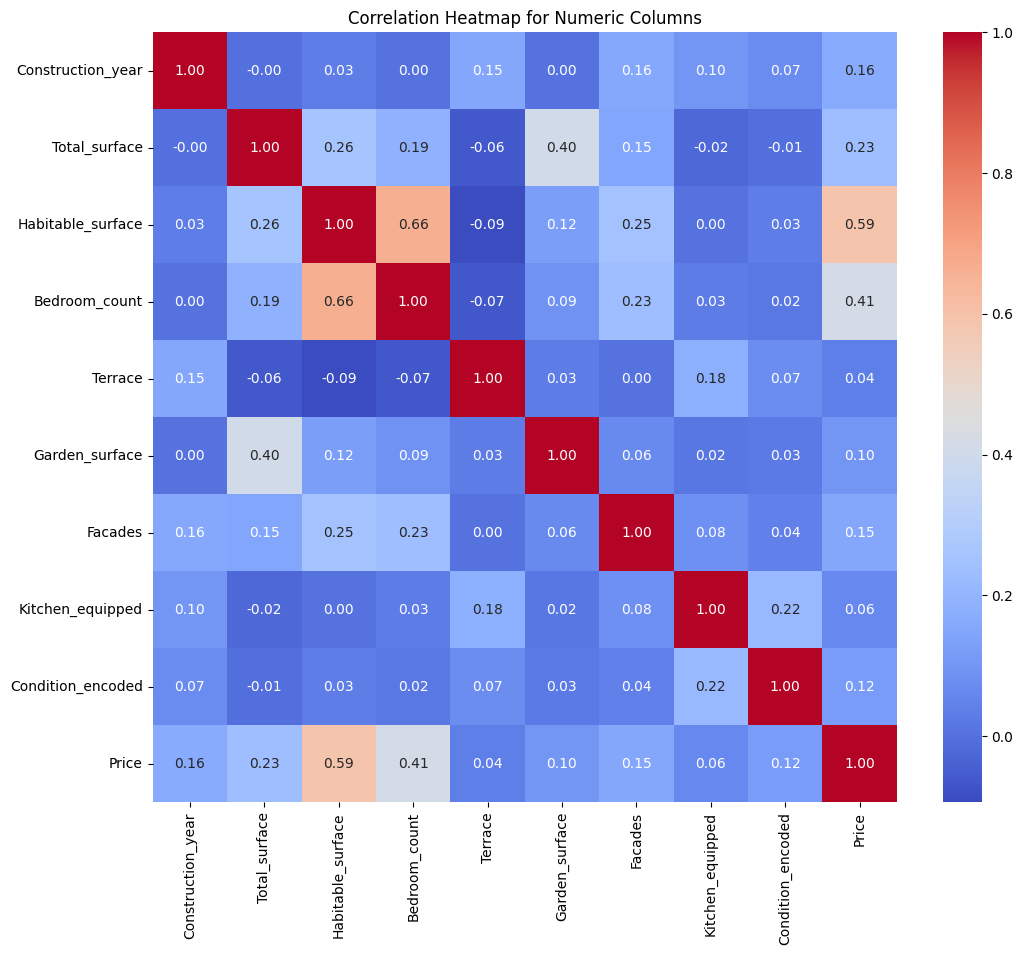

In [ ]:
columns = ['Construction_year', 'Total_surface', 'Habitable_surface', 'Bedroom_count', 'Terrace', 'Garden_surface', 'Facades', 'Kitchen_equipped', 'Condition_encoded', 'Price']
#numeric_df = df.select_dtypes(include=[float, int])
numeric_df = df_cleaned[columns]
# Compute the correlation matrix for the numeric columns
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Add a title to the heatmap
plt.title("Correlation Heatmap for Numeric Columns")

# Show the plot
plt.show()

### 4. First pipeline on the DataFrame:

Model running for house listings only

In [ ]:
X = df_cleaned.drop(columns='Price')
y = df_cleaned.Price.to_numpy().reshape(-1 , 1)
#ones = np.ones((X.shape[0],1))
#X = np.hstack((X, ones))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 123)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regressor = lr()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = regressor.score(X_train, y_train)
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true=y_test, y_pred=y_pred,)
print(score)
print(MSE)
print(X_test.shape)

ValueError: could not convert string to float: 'HOUSE'

Model for apartment listings only

In [ ]:
X = df_apt.drop(columns='Price')
y = df_apt.Price.to_numpy()
ones = np.ones((X.shape[0],1))
X = np.hstack((X, ones))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 123)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regressor = lr()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = regressor.score(X_train, y_train)
MSE = mean_squared_error(y_true=y_test, y_pred=y_pred,)
print(score)
print(MSE)


0.40753016949303855
88666619534.03943


### 5. Try a non-linear model: XGboost

In [30]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

#X = df_apt.drop(columns='Price')
#y = df_apt.Price.to_numpy().reshape(-1, 1)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Initialize and train the XGBoost regression model
xgb_model = xgb.XGBRegressor(booster='gbtree', objective="reg:squarederror", random_state=123, n_estimators=2000, learning_rate=0.02, max_depth=6)
xgb_model.fit(X_train, y_train)

# Evaluate the model on training and testing data
print("Training R-squared score:", xgb_model.score(X_train, y_train))
print("Testing R-squared score:", xgb_model.score(X_test, y_test))

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
print("Mean Squared Error:", mse)

# Perform cross-validation and compute mean and standard deviation of R-squared scores
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print("Cross-validation R2 scores:", cv_scores)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)

fig = go.Figure()

# Add actual prices and predicted prices as scatter plot traces
fig.add_trace(go.Scattergl(x=y_test.flatten(),
                           y=y_pred,
                           mode='markers',
                           marker=dict(color='blue', size=8),
                           name='Predicted vs. Actual Prices',
                           text=[f'Data Point Index: {i}' for i in np.arange(len(y_test))],
                           hoverinfo='text+x+y'))

# Add a 1:1 line (y=x) to indicate perfect predictions
diagonal_line = go.Scatter(x=[min(y_test.flatten()), max(y_test.flatten())],
                           y=[min(y_test.flatten()), max(y_test.flatten())],
                           mode='lines',
                           line=dict(color='red', dash='solid'),
                           name='Perfect Prediction')

fig.add_trace(diagonal_line)

# Update layout
fig.update_layout(title='Actual vs. Predicted Prices (Test Data)',
                  xaxis_title='Actual Price',
                  yaxis_title='Predicted Price',
                  showlegend=True,
                  hovermode='closest'
                 )

# Show the interactive plot
fig.show()

# Save the plot as an interactive HTML file in the "output" folder
output_folder = 'output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_file_path = os.path.join(output_folder, 'xgboost_actual_vs_predicted_scatterplot.html')
fig.write_html(output_file_path)

print(f"Interactive scatter plot saved as an HTML at: {output_file_path}")
# Calculate the absolute difference between the price and the predicted price
absolute_difference = abs(y_test.flatten() - y_pred)

# Create a list to store the colors for the dots based on the condition
dot_colors = ['green' if diff < 0.1 * price else 'blue' for price, diff in zip(y_test.flatten(), absolute_difference)]

# Create an interactive scatter plot of actual prices vs. predicted prices
fig = go.Figure()

# Add actual prices and predicted prices as scatter plot traces with custom colors
fig.add_trace(go.Scattergl(x=y_test.flatten(),
                           y=y_pred,
                           mode='markers',
                           marker=dict(color=dot_colors, size=8),
                           name='Predicted vs. Actual Prices',
                           text=[f'Data Point Index: {i}' for i in np.arange(len(y_test))],
                           hoverinfo='text+x+y'))

# Add a 1:1 line (y=x) to indicate perfect predictions
diagonal_line = go.Scatter(x=[min(y_test.flatten()), max(y_test.flatten())],
                           y=[min(y_test.flatten()), max(y_test.flatten())],
                           mode='lines',
                           line=dict(color='red', dash='solid'),
                           name='Perfect Prediction')

fig.add_trace(diagonal_line)

# Update layout
fig.update_layout(title='Actual vs. Predicted Prices (Test Data)',
                  xaxis_title='Actual Price',
                  yaxis_title='Predicted Price',
                  showlegend=True,
                  hovermode='closest'
                 )

# Show the interactive plot
fig.show()

# Save the plot as an interactive HTML file in the "output" folder
output_folder = 'output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_file_path = os.path.join(output_folder, 'xgboost_actual_vs_predicted_scatterplot_green.html')
fig.write_html(output_file_path)

print(f"Interactive scatter plot saved as an HTML at: {output_file_path}")

Training R-squared score: 0.9210538192416353
Testing R-squared score: 0.8046342410308897
Mean Squared Error: 33863811097.58178
Cross-validation R2 scores: [0.78514437 0.74365733 0.77955085 0.75020007 0.75043591]
Mean cross-validation R2 score: 0.7617977053250854
Standard deviation of cross-validation R2 scores: 0.0170464625041911


AttributeError: 'DataFrame' object has no attribute 'flatten'

In [ ]:
apt_columns = ['Habitable surface', 'Bedroom count', 'Terrace surface', 'Kitchen equipped', 'Floor', 'Condition_encoded']
X = df_apt[apt_columns].to_numpy()
y = df_apt.Price.to_numpy().reshape(-1 , 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
regressor = xgb.XGBRegressor(booster='gbtree', objective="reg:squarederror", random_state=123, n_estimators=2000, learning_rate=0.02, max_depth=6)
regressor.fit(X_train, y_train)
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))
y_pred = regressor.predict(X_test)
score = regressor.score(X_test, y_test)  # Use X_test and y_test for scoring
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
cv_scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring='r2')
print("Cross-validation R2 scores:", cv_scores)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
print(df.shape)
print(X.shape)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_pred, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_test.flatten(), mode='lines', name='Actual'))
fig.update_layout(title='Regression Model Results', xaxis_title='Actual Price', yaxis_title='Predicted Value')
fig.show()

0.8892885839252126
0.3618957368440764
Cross-validation R2 scores: [0.41401347 0.55573063 0.48537705 0.42307702 0.27303181]
Mean cross-validation R2 score: 0.4302459986966241
Standard deviation of cross-validation R2 scores: 0.09361305040876966
(15346, 15)
(6246, 6)


### 6. Try the complete pipeline, running the model function from linear_model.py
#### 1. Df chosen = 2 (df_house), Model 1 is XGboost()

In [ ]:
regressor, score, mse, cv_scores, mean_cv_score, std_cv_score, fig = model(1, model=1, scaled=True )
print(f'The score for the model is: {score}\nThe MSE for this model is {mse}')
print("Cross-validation R2 scores:", cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_pred, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_test.flatten(), mode='lines', name='Actual'))
fig.update_layout(title='Regression Model Results', xaxis_title='Actual Price', yaxis_title='Predicted Value')
fig.show()

ValueError: not enough values to unpack (expected 7, got 6)

#### 2. Model 2 is LinearRegression()

In [ ]:
regressor, score, mse, cv_scores, mean_cv_score, std_cv_score, fig = model(1, model=2, scaled=True )
print(f'The score for the model is: {score}\nThe MSE for this model is {mse}')
print("Cross-validation R2 scores:", cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_pred, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_test.flatten(), mode='lines', name='Actual'))
fig.update_layout(title='Regression Model Results', xaxis_title='Actual Price', yaxis_title='Predicted Value')
fig.show()

TypeError: 'XGBClassifier' object is not callable

In [ ]:
from src.clean_data import run_cleanup
from src.linear_model import model
from src.linear_model import get_model_input
from src.linear_model import get_scaled_input
from src.linear_model import get_df_input
# Get user input for model_number
while True:
    model_input = input("Choose the model (1 for Linear Regression, 2 for XGBoost): ")
    if model_input.isdigit():
        model_number = int(model_input)
        if model_number in [1, 2]:
            break
    print("Invalid input. Please enter 1 or 2.")

# Get user input for scaled
while True:
    scale_input = input("Do you want to scale the data? (y/n): ")
    if scale_input.lower() in ['y', 'n']:
        scaled = True if scale_input.lower() == 'y' else False
        break
    print("Invalid input. Please enter 'y' or 'n'.")

# Get user input for DataFrame choice
while True:
    df_input = input("Choose the DataFrame (1 for entire DataFrame, 2 for houses, 3 for apartments): ")
    if df_input.isdigit():
        df_choice = int(df_input)
        if df_choice in [1, 2, 3]:
            break
    print("Invalid input. Please enter 1, 2, or 3.")

# Get user inputs for model, scaling, and DataFrame choice
model_number = get_model_input()
scaled = get_scaled_input()
df_choice = get_df_input()

regressor, score, mse, cv_scores, mean_cv_score, std_cv_score, fig = model(df_choice,model=model_number, scaled=scaled )
print(f'The score for the model is: {score}\nThe MSE for this model is {mse}')
print("Cross-validation R2 scores:", cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
fig.show()

In [ ]:
import pickle
pickled_model = pickle.load(open("../models/df_house.pkl", "rb"))
pickled_model.n_features_in_

15